In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset Link : https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud
import re

In [ ]:
from tensorflow.keras.preprocessing.text import  Tokenizer
from tensorflow.keras.preprocessing.sequence import  pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Conv1D,MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report, accuracy_score

In [ ]:
fake_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/news_data/Fake.csv')

In [ ]:
fake_data.head

<bound method NDFrame.head of                                                    title  ...               date
0       Donald Trump Sends Out Embarrassing New Year’...  ...  December 31, 2017
1       Drunk Bragging Trump Staffer Started Russian ...  ...  December 31, 2017
2       Sheriff David Clarke Becomes An Internet Joke...  ...  December 30, 2017
3       Trump Is So Obsessed He Even Has Obama’s Name...  ...  December 29, 2017
4       Pope Francis Just Called Out Donald Trump Dur...  ...  December 25, 2017
...                                                  ...  ...                ...
23476  McPain: John McCain Furious That Iran Treated ...  ...   January 16, 2016
23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...  ...   January 16, 2016
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...  ...   January 15, 2016
23479  How to Blow $700 Million: Al Jazeera America F...  ...   January 14, 2016
23480  10 U.S. Navy Sailors Held by Iranian Military ...  ...   January 12, 201

In [ ]:
fake_data.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [ ]:
fake_data['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

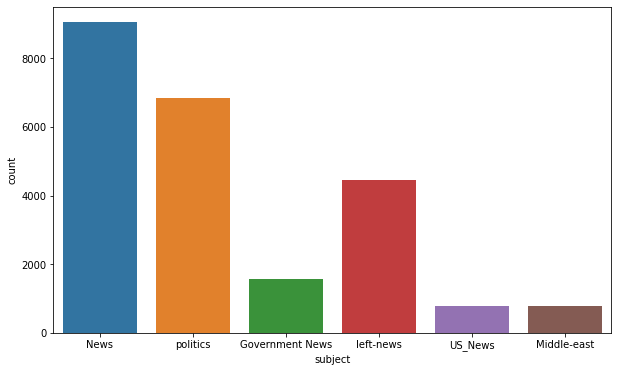

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x = 'subject',data=fake_data)

In [ ]:
fake_data['text'].tolist()

['Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t e

In [ ]:
ftext = ' '.join(fake_data['text'].tolist())

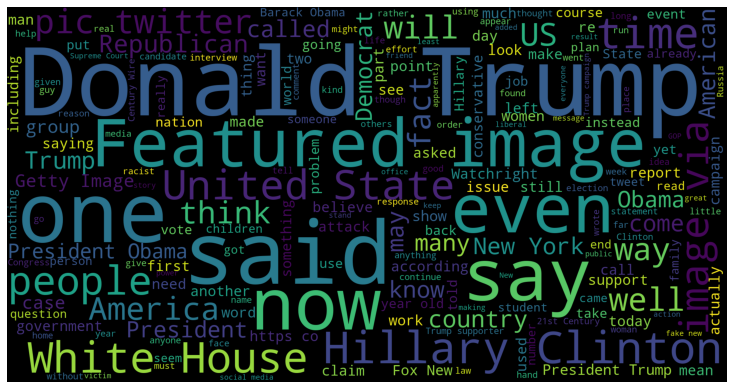

In [ ]:
wordcloud = WordCloud(width=1920, height=1000).generate(ftext)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
real_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/news_data/True.csv')

In [ ]:
rtext = ' '.join(real_data['text'].tolist())

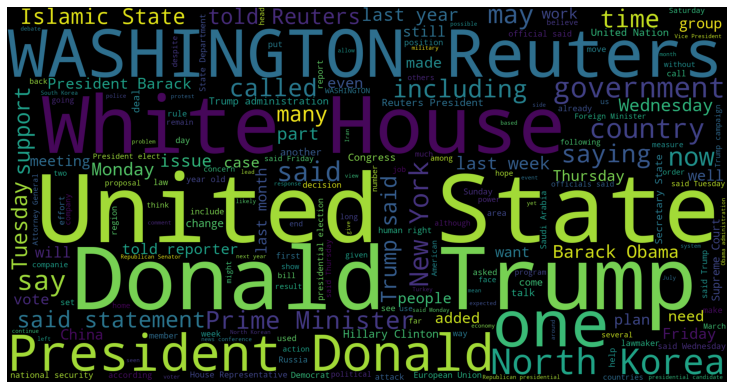

In [ ]:
wordcloud = WordCloud(width=1920, height=1000).generate(rtext)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
real_data.sample(5)

,title,text,subject,date
9580,"Brexit would hurt Britain, EU and global econo...",BERLIN (Reuters) - If Britain were to leave th...,politicsNews,"May 12, 2016"
7959,U.S. lawmakers may change September 11 law aft...,WASHINGTON (Reuters) - U.S. lawmakers expresse...,politicsNews,"September 29, 2016"
1350,"Democratic Senator Feinstein, 84, 'all in' on ...",WASHINGTON (Reuters) - Democrat Dianne Feinste...,politicsNews,"October 9, 2017"
4317,U.S. anti-border tax coalition to target lawma...,WASHINGTON (Reuters) - Opponents of a proposal...,politicsNews,"April 10, 2017"
19938,Russia: Syria government forces now on east ba...,MOSCOW (Reuters) - Advance units of the Syrian...,worldnews,"September 15, 2017"


In [ ]:
unknown_publisher = []
for index, row in enumerate(real_data.text.values):
  try:
    record = row.split('-', maxsplit=1)
    record[1]

    assert(len(record[0])<120)
  except:
    unknown_publisher.append(index)

In [ ]:
len(unknown_publisher)

222

In [ ]:
real_data.iloc[unknown_publisher].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 222, dtype: object

In [ ]:
real_data.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [ ]:
real_data=real_data.drop(8970, axis=0)

In [ ]:
publisher = []
tmp_text = []

for index, row in enumerate(real_data.text.values):
  if index in unknown_publisher:
    tmp_text.append(row)
    publisher.append('Unknown')

  else:
    record = row.split('-',maxsplit=1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())

In [ ]:
real_data['publisher']=publisher
real_data['text'] = tmp_text

In [ ]:
real_data.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [ ]:
real_data.shape

(21416, 5)

In [ ]:
empty_fake_data_index = [index for index,text in enumerate(fake_data.text.to_list()) if str(text).strip()==""]

In [ ]:
fake_data.iloc[empty_fake_data_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [ ]:
real_data['text'] = real_data['title'] + " " + real_data['text']
fake_data['text'] = fake_data['title'] + " " + fake_data['text']

In [ ]:
real_data['text'] = real_data['text'].apply(lambda x: str(x).lower())
fake_data['text'] = fake_data['text'].apply(lambda x: str(x).lower())

In [ ]:
real_data['class'] = 1
fake_data['class'] = 0

In [ ]:
real_data.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object')

In [ ]:
real_data = real_data[['text', 'class']]

In [ ]:
fake_data = fake_data[['text', 'class']]

In [ ]:
data = real_data.append(fake_data, ignore_index=True)

In [ ]:
data.sample(5)

,text,class
14012,mexican leftist lopez obrador leads presidenti...,1
33393,a-list democrats attend obama’s last taxpayer-...,0
7305,abe aims to underscore importance of japan-u.s...,1
3498,ex-naacp chief ben jealous to run for maryland...,1
25227,trump brings us dangerously close to state-ru...,0


In [ ]:
#https://github.com/laxmimerit/preprocess_kgptalkie

In [ ]:
!pip install spacy==2.2.3
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

     |████████████████████████████████| 10.4 MB 5.0 MB/s 
     |████████████████████████████████| 2.2 MB 37.7 MB/s 
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 12.0 MB 5.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 115 kB 5.4 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-h62ibycs
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip

In [ ]:
import preprocess_kgptalkie as ps
data['text'] = data['text'].apply(lambda x: ps.remove_special_chars(x))

In [ ]:
ps.remove_special_chars('this ,. @ # is gre@t')

'this is gret'

In [ ]:
import gensim

In [ ]:
y = data['class'].values

In [ ]:
X = [d.split() for d in data['text'].tolist()]

In [ ]:
type(X[0])

list

In [ ]:
print (X[0])

['as', 'us', 'budget', 'fight', 'looms', 'republicans', 'flip', 'their', 'fiscal', 'script', 'the', 'head', 'of', 'a', 'conservative', 'republican', 'faction', 'in', 'the', 'us', 'congress', 'who', 'voted', 'this', 'month', 'for', 'a', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cuts', 'called', 'himself', 'a', 'fiscal', 'conservative', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', '2018', 'in', 'keeping', 'with', 'a', 'sharp', 'pivot', 'under', 'way', 'among', 'republicans', 'us', 'representative', 'mark', 'meadows', 'speaking', 'on', 'cbs', 'face', 'the', 'nation', 'drew', 'a', 'hard', 'line', 'on', 'federal', 'spending', 'which', 'lawmakers', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january', 'when', 'they', 'return', 'from', 'the', 'holidays', 'on', 'wednesday', 'lawmakers', 'will', 'begin', 'trying', 'to', 'pass', 'a', 'federal', 'budget', 'in', 'a', 'fight', 'likely', 'to', 'be', 'linked', 'to', 'other', 'issues',

In [ ]:
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, size=DIM, window=10, min_count=1)

In [ ]:
len(w2v_model.wv.vocab)

231872

In [ ]:
w2v_model.wv['love']

array([ 2.2786477 ,  0.8589793 , -0.5998819 , -0.75372744, -0.25047654,
        1.3449677 , -2.9433174 ,  1.0632423 ,  0.6351137 ,  1.670252  ,
        4.264528  , -2.0230832 ,  0.8994939 ,  1.2401237 , -3.6985412 ,
        1.8091978 , -1.874786  , -1.8843526 , -1.4181533 ,  0.2129735 ,
        0.06740539, -2.4856892 , -2.057169  ,  1.6592783 ,  0.53480154,
       -0.14284363, -3.6448965 ,  2.9761581 ,  0.50810164,  1.1068114 ,
       -0.89771307,  1.2821997 , -2.2279084 , -0.2854745 ,  0.35537016,
        2.5095034 ,  1.6214077 ,  0.7072443 ,  4.5832524 , -2.8810437 ,
        1.7570941 ,  4.4975057 , -1.9156905 , -4.623539  ,  0.2286519 ,
       -0.32553884, -2.9697917 , -1.8984323 , -0.57762897, -0.506925  ,
        2.843074  ,  1.5407724 , -3.6630254 , -1.1139156 , -3.6504176 ,
        1.608636  ,  0.10050368, -0.86031485,  1.6886142 , -0.5862603 ,
        3.169146  , -1.4307823 , -0.23939574,  1.3943714 ,  1.7973142 ,
        0.8539936 , -0.56989   ,  0.7934842 , -2.5188594 ,  4.61

In [ ]:
w2v_model.wv.most_similar('india')

[('pakistan', 0.7448636293411255),
 ('malaysia', 0.7210619449615479),
 ('china', 0.647531270980835),
 ('thailand', 0.6238649487495422),
 ('philippines', 0.6149389743804932),
 ('indian', 0.6104438900947571),
 ('modi', 0.6045128107070923),
 ('australia', 0.5981023907661438),
 ('indias', 0.5972357988357544),
 ('beijings', 0.5927143096923828)]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [ ]:
X = tokenizer.texts_to_sequences(X)

In [ ]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'a': 4,
 'and': 5,
 'in': 6,
 'that': 7,
 'on': 8,
 'for': 9,
 's': 10,
 'is': 11,
 'he': 12,
 'said': 13,
 'trump': 14,
 'it': 15,
 'with': 16,
 'was': 17,
 'as': 18,
 'his': 19,
 'by': 20,
 'has': 21,
 'be': 22,
 'have': 23,
 'not': 24,
 'from': 25,
 'this': 26,
 'at': 27,
 'are': 28,
 'who': 29,
 'us': 30,
 'an': 31,
 'they': 32,
 'i': 33,
 'but': 34,
 'we': 35,
 'would': 36,
 'president': 37,
 'about': 38,
 'will': 39,
 'their': 40,
 'had': 41,
 'you': 42,
 't': 43,
 'been': 44,
 'were': 45,
 'people': 46,
 'more': 47,
 'or': 48,
 'after': 49,
 'which': 50,
 'she': 51,
 'her': 52,
 'one': 53,
 'if': 54,
 'its': 55,
 'out': 56,
 'all': 57,
 'what': 58,
 'state': 59,
 'when': 60,
 'new': 61,
 'also': 62,
 'up': 63,
 'there': 64,
 'over': 65,
 'no': 66,
 'house': 67,
 'donald': 68,
 'our': 69,
 'states': 70,
 'clinton': 71,
 'obama': 72,
 'government': 73,
 'can': 74,
 'just': 75,
 'him': 76,
 'so': 77,
 'than': 78,
 'republican': 79,
 'other': 80,
 'so

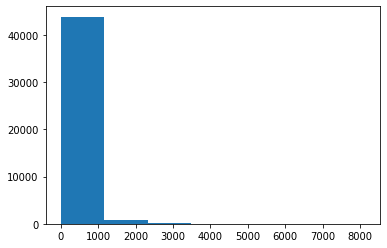

In [ ]:
plt.hist([len(x) for x in X], bins =7)
plt.show()

In [ ]:
nos = np.array([len(x) for x in X])
len(nos[nos>1000])

1581

In [ ]:
maxlen = 1000
X = pad_sequences(X, maxlen=maxlen)

In [ ]:
len(X[101])

1000

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab = tokenizer.word_index

In [ ]:
def get_weight_marix(model):
  weight_marix = np.zeros((vocab_size, DIM))

  for word, i in vocab.items():
    weight_marix[i] = model.wv[word]

  return weight_marix

In [ ]:
emb_vectors = get_weight_marix(w2v_model)

In [ ]:
emb_vectors.shape

(231873, 100)

MODEL

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=DIM, weights = [emb_vectors], input_length=maxlen, trainable=True))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1000, 100)         23187300  
                                                                 
 lstm_2 (LSTM)               (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,304,677
Trainable params: 23,304,677
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [ ]:
model.fit(X_train, y_train, validation_split=0.3, epochs=10)

Epoch 1/10
737/737 [==============================] - 134s 182ms/step - loss: 3.9622e-06 - acc: 1.0000 - val_loss: 0.0504 - val_acc: 0.9930
Epoch 2/10
737/737 [==============================] - 134s 182ms/step - loss: 0.0062 - acc: 0.9980 - val_loss: 0.0415 - val_acc: 0.9916
Epoch 3/10
737/737 [==============================] - 134s 182ms/step - loss: 0.0019 - acc: 0.9993 - val_loss: 0.0453 - val_acc: 0.9921
Epoch 4/10
737/737 [==============================] - 140s 190ms/step - loss: 5.8821e-05 - acc: 1.0000 - val_loss: 0.0479 - val_acc: 0.9922
Epoch 5/10
737/737 [==============================] - 134s 182ms/step - loss: 2.4479e-05 - acc: 1.0000 - val_loss: 0.0493 - val_acc: 0.9924
Epoch 6/10
737/737 [==============================] - 134s 182ms/step - loss: 1.6534e-05 - acc: 1.0000 - val_loss: 0.0507 - val_acc: 0.9924
Epoch 7/10
737/737 [==============================] - 134s 182ms/step - loss: 1.1295e-05 - acc: 1.0000 - val_loss: 0.0519 - val_acc: 0.9922
Epoch 8/10
737/737 [========

In [ ]:
y_pred = (model.predict(X_test) >= 0.5).astype(int)

In [ ]:
accuracy_score(y_test,y_pred)

0.9918040089086859

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5877
           1       0.99      1.00      0.99      5348

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225

